In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Mon Feb 21 05:28:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fine-Tuning Vision Transformers for Image Classification

Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. It's quite a simple concept, really...

1. Split an image into a grid of sub-image patches
2. Embed each path with a linear projection
3. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)

It turns out that once you've done the above, you can pre-train and finetune transformers just as you're used to with NLP tasks. Pretty sweet 😎.

---

In this notebook, we'll walk through how to leverage `malware datasets` and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 `transformers`.

To get started, lets first install both those packages.

In [3]:
# blocks output in Colab 💄

! pip install datasets transformers

     |████████████████████████████████| 311 kB 8.9 MB/s 
     |████████████████████████████████| 3.5 MB 34.5 MB/s 
     |████████████████████████████████| 1.1 MB 80.2 MB/s 
     |████████████████████████████████| 133 kB 86.7 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 243 kB 79.5 MB/s 
     |████████████████████████████████| 6.8 MB 53.3 MB/s 
     |████████████████████████████████| 895 kB 63.4 MB/s 
     |████████████████████████████████| 596 kB 70.9 MB/s 
     |████████████████████████████████| 271 kB 95.6 MB/s 
     |████████████████████████████████| 144 kB 89.6 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the `normalized-set dataset`, which is a collection of pictures of malware and benign. 👾

In [34]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os

imageDim = 224
dirPath = '/content/drive/MyDrive/normalized-set'
batchSize = 32

In [35]:
def LoadDataset(_dataset):
    dsPath = os.path.join(dirPath, _dataset)
    dataGenerator = transforms.Compose([
        transforms.Resize((imageDim, imageDim)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataFolder = torchvision.datasets.ImageFolder(
        root = dsPath,
        transform = dataGenerator,
    )

    datasetLoader = DataLoader(
        dataFolder,
        batch_size=batchSize,
        shuffle=True,
    )

    datasetLoader.requires_grad = True

    print(_dataset + " Class [", datasetLoader.dataset.class_to_idx, "]")
    print(_dataset + " Numbers [", len(datasetLoader.dataset.imgs), "]")
    print(_dataset + " Batch Size [", datasetLoader.batch_size, "]")

    return datasetLoader

In [36]:
trainDataset = LoadDataset('training')
validationDataset = LoadDataset('validation')
testDataset = LoadDataset('test')

training Class [ {'benign': 0, 'malware': 1} ]
training Numbers [ 24130 ]
training Batch Size [ 32 ]
validation Class [ {'benign': 0, 'malware': 1} ]
validation Numbers [ 6890 ]
validation Batch Size [ 32 ]
test Class [ {'benign': 0, 'malware': 1} ]
test Numbers [ 3442 ]
test Batch Size [ 32 ]


Let's take a look at the image 👀

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


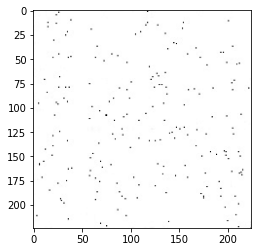

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def CustomImshow(_img):
    # img = _img.to_numpy()
    img = _img.numpy()
    print(img.shape)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

sampleData, sampleLabel = next(iter(trainDataset))
CustomImshow(sampleData[0])

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model.

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so let's load its feature extractor from the 🤗 Hub.

In [9]:
from transformers import ViTFeatureExtractor

modelNameOrPath = 'google/vit-base-patch16-224-in21k'
featureExtractor = ViTFeatureExtractor.from_pretrained(modelNameOrPath)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

If we print a feature extractor, we can see its configuration.

In [10]:
featureExtractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

## Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:
- Define a collate function
- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.
- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.
- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

## Define our data collator

Batches are coming in as lists of tensors, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [11]:
import torch

def CollateFn(_batch):
    return {
        'pixel_values': torch.stack([x[0] for x in _batch]),
        'labels': torch.tensor([x[1] for x in _batch])
    }

## Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [12]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def ComputeMetrics(_p):
    return metric.compute(predictions=np.argmax(_p.predictions, axis=1), references=_p.label_ids)

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

In [13]:
trainDataset.dataset.classes

['benign', 'malware']

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [14]:
from transformers import ViTForImageClassification

labels = trainDataset.dataset.classes

model = ViTForImageClassification.from_pretrained(
    modelNameOrPath,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by difining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused fatures (`image`in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [19]:
from transformers import TrainingArguments

trainingArgs = TrainingArguments(
    output_dir="/content/drive/MyDrive/vit-base-demo-v5",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

PyTorch: setting up devices


Now, all instances can be passed to Trainer and we are ready to start training!

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=trainingArgs,
    data_collator=CollateFn,
    compute_metrics=ComputeMetrics,
    train_dataset=trainDataset.dataset,
    eval_dataset=validationDataset.dataset,
    tokenizer=featureExtractor,
)

Using amp half precision backend


In [21]:
trainResults = trainer.train()
trainer.save_model()
trainer.log_metrics("train", trainResults.metrics)
trainer.save_metrics("train", trainResults.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 24130
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6036


Step,Training Loss,Validation Loss,Accuracy
100,0.693500,0.608569,0.667344
200,0.566400,0.511039,0.748766
300,0.554700,0.432781,0.810740
400,0.344700,0.418432,0.820755
500,0.443600,0.392833,0.822206
600,0.394200,0.330581,0.853556
700,0.364900,0.354947,0.841800
800,0.420800,0.382013,0.836430
900,0.353800,0.313121,0.871263
1000,0.299900,0.341628,0.859216


***** Running Evaluation *****
  Num examples = 6890
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/vit-base-demo-v5/checkpoint-100
Configuration saved in /content/drive/MyDrive/vit-base-demo-v5/checkpoint-100/config.json
Model weights saved in /content/drive/MyDrive/vit-base-demo-v5/checkpoint-100/pytorch_model.bin
Configuration saved in /content/drive/MyDrive/vit-base-demo-v5/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6890
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/vit-base-demo-v5/checkpoint-200
Configuration saved in /content/drive/MyDrive/vit-base-demo-v5/checkpoint-200/config.json
Model weights saved in /content/drive/MyDrive/vit-base-demo-v5/checkpoint-200/pytorch_model.bin
Configuration saved in /content/drive/MyDrive/vit-base-demo-v5/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6890
  Batch size = 8
Saving model checkpoint to /content/drive/MyDriv

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 6965852191GF
  train_loss               =        0.239
  train_runtime            =   4:24:03.02
  train_samples_per_second =        6.092
  train_steps_per_second   =        0.381


In [37]:
metrics = trainer.evaluate(testDataset.dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9079
  eval_loss               =      0.214
  eval_runtime            = 0:08:54.95
  eval_samples_per_second =      6.434
  eval_steps_per_second   =      0.806
